In [22]:
import pandas as pd
import helpers
import numpy as np
pd.set_option('display.max_columns', None)
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('./data/features.csv', index_col='match_id')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB


In [7]:
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,1,11,4,3,1058,996,12,0,0,6,42,4,1085,986,12,0,0,4,21,5,2052,1536,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,0,5,39,5,1960,1384,16,0,0,8,88,3,640,566,1,0,1,5,79,3,720,1350,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,0,9,22,5,2305,2028,19,1,1,10,66,3,1024,959,19,0,1,10,86,3,755,620,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,0,6,96,5,1878,1174,17,0,0,6,48,3,732,1468,22,0,0,10,15,4,1681,1051,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,0,8,26,3,704,586,1,0,2,9,69,3,1169,1665,20,1,0,7,22,3,1055,638,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


**Проверка на наличие пропусков**

In [8]:
desc = df.describe()
rows = df.shape[0]
counts = desc.T['count']
counts_na = counts[counts < rows]
counts_na.sort_values().apply(lambda a: (rows - a) / rows)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
Name: count, dtype: float64

In [9]:
",".join(counts_na.keys())

'first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_first_ward_time'

**Загрузка данных**

In [11]:
train = pd.read_csv('./data/features.csv', index_col='match_id')
test = pd.read_csv('./data/features_test.csv', index_col='match_id')

**Удаление признаков, вносящих вклад в предсказание**

In [12]:
train.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)

**Разделение данных на признаки и целевую переменную**

In [13]:
X = train
y = train['radiant_win'].to_frame()
del train['radiant_win']

**Замена пропусков на нули**

In [14]:
def clean(X):
    return X.fillna(0)

**Сохранение изменённых даных**

In [15]:
helpers.save_clean_data(clean, X, y, test)

**Кросс-валидация**

In [16]:
X, y, X_kaggle = helpers.get_clean_data()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

**Выбор числа деревьев**

In [20]:
scores = []
nums = [10, 20, 30, 50, 70, 100, 120]
for n in nums:
    print('n_estimators = ', str(n))
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)
    start_time = datetime.datetime.now()
    model_scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
    print('Time elapsed:', datetime.datetime.now() - start_time)
    print(model_scores)
    scores.append(np.mean(model_scores))

n_estimators =  10
Time elapsed: 0:00:32.695191
[0.66383799 0.66635457 0.66360048 0.66529818 0.66516222]
n_estimators =  20
Time elapsed: 0:01:01.357370
[0.68083889 0.68272733 0.67969876 0.6834932  0.6855512 ]
n_estimators =  30
Time elapsed: 0:01:27.467459
[0.68892093 0.68934663 0.68712298 0.69180598 0.69283583]
n_estimators =  50
Time elapsed: 0:02:27.120371
[0.69627399 0.69747879 0.69470891 0.69921915 0.69979097]
n_estimators =  70
Time elapsed: 0:03:19.206734
[0.70120426 0.7018134  0.699683   0.70399032 0.70389172]
n_estimators =  100
Time elapsed: 0:04:44.378981
[0.70515496 0.706077   0.70429951 0.7074682  0.70811523]
n_estimators =  120
Time elapsed: 0:06:02.834216
[0.70662045 0.70778703 0.70667084 0.70942825 0.71040816]


**График зависимости качества от количества деревьев**

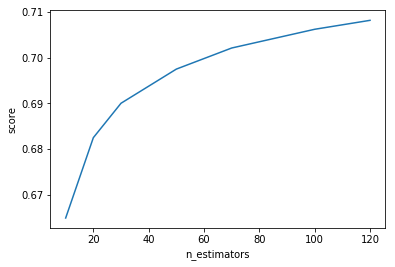

In [21]:
plt.plot(nums, scores)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

**Логистическая регрессия**

In [24]:
X, y, X_kaggle = helpers.get_clean_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [26]:
def plot_C_scores(C_pow_range, scores):
    plt.plot(C_pow_range, scores)
    plt.xlabel('log(C)')
    plt.ylabel('score')
    plt.show()

def test_model_C(X, y, C):
    print('C =', str(C))
    model = LogisticRegression(C=C, random_state=42, n_jobs=-1)
    return cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
    
def test_model(X, y):
    scores = []
    C_pow_range = range(-5, 6)
    C_range = [10.0 ** i for i in C_pow_range]
    for C in C_range:
        start_time = datetime.datetime.now()
        model_scores = test_model_C(X, y, C)
        print(model_scores)
        print('Time elapsed:', datetime.datetime.now() - start_time)     
        scores.append(np.mean(model_scores))

    plot_C_scores(C_pow_range, scores)
    
    max_score = max(scores)
    max_score_index = scores.index(max_score)
    return C_range[max_score_index], max_score

C = 1e-05
[0.6931532  0.69481539 0.69571379 0.69513159 0.69699445]
Time elapsed: 0:00:06.639530
C = 0.0001
[0.70956686 0.71039474 0.71170336 0.71176082 0.71336295]
Time elapsed: 0:00:05.274361
C = 0.001
[0.71449541 0.71577214 0.71625974 0.71697301 0.71831738]
Time elapsed: 0:00:08.576251
C = 0.01
[0.71464598 0.71617915 0.71624749 0.71735041 0.71832832]
Time elapsed: 0:00:10.432412
C = 0.1
[0.71462192 0.71617479 0.71619187 0.71737596 0.7182712 ]
Time elapsed: 0:00:12.770067
C = 1.0
[0.71461815 0.71617185 0.71618338 0.7173762  0.71826341]
Time elapsed: 0:00:12.034785
C = 10.0
[0.71461695 0.71617179 0.71618281 0.71737669 0.7182632 ]
Time elapsed: 0:00:13.380539
C = 100.0
[0.71461692 0.71617206 0.71618249 0.71737655 0.71826345]
Time elapsed: 0:00:12.528783
C = 1000.0
[0.71461693 0.71617214 0.7161825  0.71737659 0.71826346]
Time elapsed: 0:00:12.623351
C = 10000.0
[0.71461693 0.71617215 0.71618251 0.7173766  0.71826345]
Time elapsed: 0:00:13.507128
C = 100000.0
[0.71461693 0.71617215 0.7161

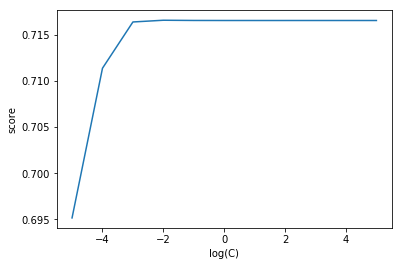

In [27]:
C, score = test_model(X, y)

**Удаление категориальных признаков**

In [29]:
X, y, X_kaggle = helpers.get_clean_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


C = 1e-05
[0.6931532  0.69481539 0.69571379 0.69513159 0.69699445]
Time elapsed: 0:00:12.733558
C = 0.0001
[0.70956686 0.71039474 0.71170336 0.71176082 0.71336295]
Time elapsed: 0:00:04.418393
C = 0.001
[0.71449541 0.71577214 0.71625974 0.71697301 0.71831738]
Time elapsed: 0:00:07.922920
C = 0.01
[0.71464598 0.71617915 0.71624749 0.71735041 0.71832832]
Time elapsed: 0:00:09.892611
C = 0.1
[0.71462192 0.71617479 0.71619187 0.71737596 0.7182712 ]
Time elapsed: 0:00:10.860941
C = 1.0
[0.71461815 0.71617185 0.71618338 0.7173762  0.71826341]
Time elapsed: 0:00:10.849959
C = 10.0
[0.71461695 0.71617179 0.71618281 0.71737669 0.7182632 ]
Time elapsed: 0:00:10.845741
C = 100.0
[0.71461692 0.71617206 0.71618249 0.71737655 0.71826345]
Time elapsed: 0:00:10.842966
C = 1000.0
[0.71461693 0.71617214 0.7161825  0.71737659 0.71826346]
Time elapsed: 0:00:10.838844
C = 10000.0
[0.71461693 0.71617215 0.71618251 0.7173766  0.71826345]
Time elapsed: 0:00:10.832303
C = 100000.0
[0.71461693 0.71617215 0.7161

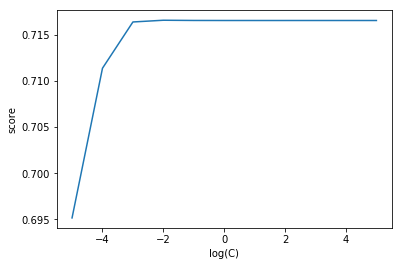

In [30]:
C, score = test_model(X, y)

**Идентификатор героев**

In [34]:
df['hero_id'].value_counts()

KeyError: 'hero_id'

In [38]:
X, y, X_kaggle = helpers.get_clean_data()
X_hero, _y, X_kaggle_hero = helpers.get_clean_data()

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index)
X_kaggle = pd.DataFrame(scaler.transform(X_kaggle), index = X_kaggle.index)

X = pd.concat([X, X_hero], axis=1)
X_kaggle = pd.concat([X_kaggle, X_kaggle_hero], axis=1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


C = 1e-05
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:02:53.619533
C = 0.0001
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:01:12.503176
C = 0.001
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:18.900546
C = 0.01
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:26.453338
C = 0.1
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:20.098415
C = 1.0
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:10.783318
C = 10.0
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:04.699506
C = 100.0
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:03.893210
C = 1000.0
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:03.941266
C = 10000.0
[0.51184163 0.51560695 0.51597178 0.50921324 0.51460449]
Time elapsed: 0:00:03.836010
C = 100000.0
[0.51184163 0.51560695 0.5159

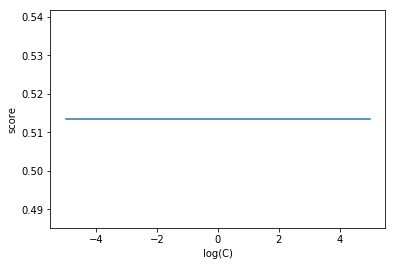

In [39]:
C, score = test_model(X, y)